<a href="https://colab.research.google.com/github/Mdasiftalukdar/Medical-Image-Classification-Employing-DCGAN-and-CNN-Transfer-Learning-Techniques/blob/main/CNN_Before_CDGAN_on_X_ray_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf

# folder
import os
import glob


import cv2
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

import seaborn as sns

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [ ]:
image_width=128
image_height=128

In [ ]:
widths = []
heights = []


for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        print(set_ + '/' + cat + '/')
        for fname in filelist:
            widths.append(Image.open(fname).size[0])
            heights.append(Image.open(fname).size[1])
        

images_size = pd.DataFrame({"widths": widths, "heights": heights})

print("min image width: " + f'{images_size["widths"].min():.2f}')
print("min image height: " + f'{images_size["heights"].min():.2f}')
print("max image width: " + f'{images_size["widths"].max():.2f}')
print("max image height: " + f'{images_size["heights"].max():.2f}')        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

train/NORMAL/
train/PNEUMONIA/
test/NORMAL/
test/PNEUMONIA/
val/NORMAL/
val/PNEUMONIA/
min image width: 384.00
min image height: 127.00
max image width: 2916.00
max image height: 2713.00
Average image width: 1327.88
Average image height: 970.69


In [ ]:
%%time
data = []
target = []

for set_ in datasets:
    for cat in categories:
        print(set_ + '/' + cat + '/')
        filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((image_height, image_width))) for fname in filelist])


train/NORMAL/
train/PNEUMONIA/
test/NORMAL/
test/PNEUMONIA/
val/NORMAL/
val/PNEUMONIA/
CPU times: user 1min 36s, sys: 3.53 s, total: 1min 39s
Wall time: 15min 45s


In [ ]:
print(np.array(data).shape)
print(np.array(target).shape)

(5856, 128, 128)
(5856,)


In [ ]:
pd.concat([pd.DataFrame(pd.DataFrame({"Target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})
           ], axis=1)

,count,%
Target,,
PNEUMONIA,4273,73
NORMAL,1583,27


In [ ]:
data_array = np.stack(data, axis=0)

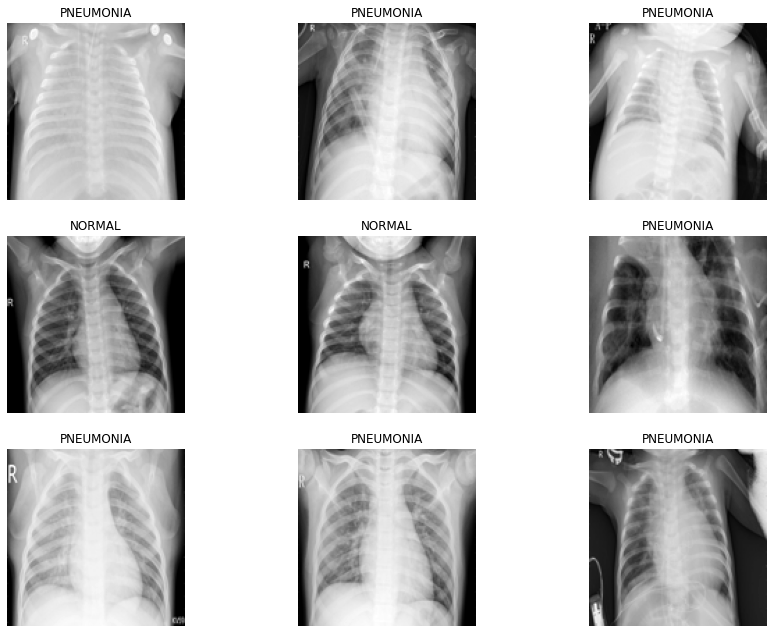

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [ ]:
print(X_train.shape)
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_train.sav'
pickle.dump(X_train, open(filename, 'wb'))

print(X_test.shape)
filename2 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_test.sav'
pickle.dump(X_test, open(filename2, 'wb'))

print(y_train.shape)
filename3 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_train.sav'
pickle.dump(y_train, open(filename3, 'wb'))

print(y_test.shape)

filename4 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_test.sav'
pickle.dump(y_test, open(filename4, 'wb'))


(4684, 128, 128)
(1172, 128, 128)
(4684,)
(1172,)


In [ ]:
pd.DataFrame(y_train).value_counts()/len(y_train)

PNEUMONIA    0.729718
NORMAL       0.270282
dtype: float64

In [ ]:
pd.DataFrame(y_test).value_counts()/len(y_test)

PNEUMONIA    0.729522
NORMAL       0.270478
dtype: float64

In [ ]:
print(X_train.max())
print(X_train.min())

255
0


In [ ]:
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [ ]:
print(X_train_norm.max())
print(X_train_norm.min())

1.0
0.0


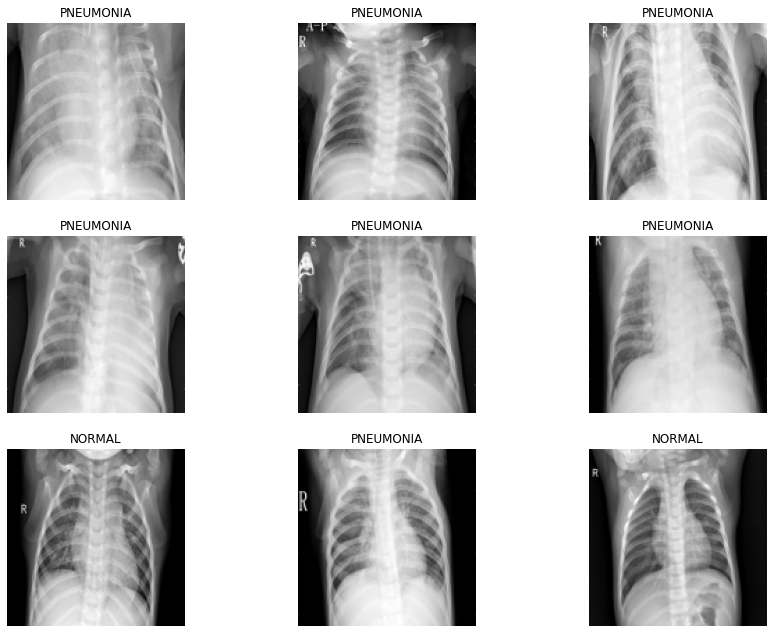

In [ ]:
#images after normalization
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

In [ ]:
display(np.array(y_train).shape)
display(np.unique(y_train))
display(np.array(y_test).shape)
display(np.unique(y_test))
print(y_test)

(4684,)

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

(1172,)

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

['PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' ... 'NORMAL' 'NORMAL' 'PNEUMONIA']


In [ ]:
encoder = LabelEncoder().fit(y_train) #normal = 0, pneumonia = 1
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

In [ ]:
print(X_train_norm.shape)
print(X_test_norm.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)
display(np.unique(y_test_cat))
print(y_test_cat)

(4684, 128, 128)
(1172, 128, 128)
(4684,)
(1172,)


array([0, 1])

[1 1 1 ... 0 0 1]


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/X_train_norm.sav'
# pickle.dump(X_train_norm, open(filename, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/X_test_norm.sav'
# pickle.dump(X_test_norm, open(filename1, 'wb'))

X_train_norm = pickle.load(open(filename, 'rb'))
x_test_norm = pickle.load(open(filename1, 'rb'))

In [ ]:
#for coustom cnn with 1 dimension
X_train_cnn = X_train_norm.reshape(-1, image_width, image_height, 1)
X_test_cnn = X_test_norm.reshape(-1, image_width, image_height, 1)
print(X_train_cnn.shape)
print(X_test_cnn.shape)

(4684, 128, 128, 1)
(1172, 128, 128, 1)


In [ ]:
#for transfer learning models
X_train_tl = np.repeat(X_train_norm[..., np.newaxis], 3, -1)
X_test_tl = np.repeat(X_test_norm[..., np.newaxis], 3, -1)
print(X_train_tl.shape)
print(X_test_tl.shape)

(4684, 128, 128, 3)
(1172, 128, 128, 3)


In [ ]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(4684,)
(1172,)


# **Custom CNN**

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(image_height, image_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
%%time
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

cnn_gan = model.fit(X_train_cnn, y_train_cat,
                    batch_size=8,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/20
410/410 [==============================] - 10s 22ms/step - loss: 0.3589 - accuracy: 0.8478 - val_loss: 0.2526 - val_accuracy: 0.9075
Epoch 2/20
410/410 [==============================] - 8s 20ms/step - loss: 0.1946 - accuracy: 0.9240 - val_loss: 0.1361 - val_accuracy: 0.9424
Epoch 3/20
410/410 [==============================] - 8s 20ms/step - loss: 0.1543 - accuracy: 0.9405 - val_loss: 0.1512 - val_accuracy: 0.9395
Epoch 4/20
410/410 [==============================] - 8s 20ms/step - loss: 0.1305 - accuracy: 0.9545 - val_loss: 0.1408 - val_accuracy: 0.9495
Epoch 5/20
410/410 [==============================] - 8s 20ms/step - loss: 0.1119 - accuracy: 0.9585 - val_loss: 0.1596 - val_accuracy: 0.9459
Epoch 6/20
410/410 [==============================] - 8s 20ms/step - loss: 0.0971 - accuracy: 0.9686 - val_loss: 0.1027 - val_accuracy: 0.9587
Epoch 7/20
410/410 [==============================] - 8s 20ms/step - loss: 0.0879 - accuracy: 0.9674 - val_loss: 0.1157 - val_accuracy: 0.957

In [ ]:
model.evaluate(X_test_cnn, y_test_cat, verbose=1)

37/37 [==============================] - 1s 16ms/step - loss: 0.2923 - accuracy: 0.9403


[0.2923119068145752, 0.9402730464935303]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/custom_CNN.sav'
pickle.dump(model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/custom_CNN_fit.sav'
pickle.dump(cnn_gan, open(filenamefit, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_cnn.sav'
pickle.dump(X_test_cnn, open(filename1, 'wb'))

filename2 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_cnn.sav'
pickle.dump(y_test_cat, open(filename2, 'wb'))

INFO:tensorflow:Assets written to: ram://dcf02dc4-1368-41d9-a5f8-e49463df6035/assets
INFO:tensorflow:Assets written to: ram://6f94f034-eb84-4398-b3d8-8080c6b717e0/assets


In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_cnn_fit = pickle.load(open(filenamefit, 'rb'))
x_cnn = pickle.load(open(filename1, 'rb'))
y = pickle.load(open(filename2, 'rb'))
loaded_model.evaluate(x_cnn, y, verbose=1)

37/37 [==============================] - 1s 16ms/step - loss: 0.2923 - accuracy: 0.9403


[0.2923119068145752, 0.9402730464935303]

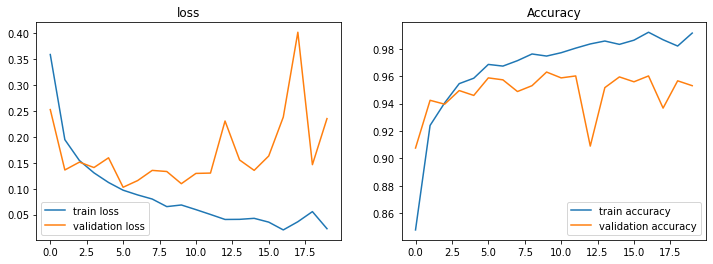

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train loss' + exp_name)
    ax1.plot(history.history['val_loss'], label='validation loss' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='validation accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(cnn_gan, title='', axs=None, exp_name="");

In [ ]:
y_pred = loaded_model.predict(x_cnn)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
 print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       317
           1       0.96      0.96      0.96       855

    accuracy                           0.94      1172
   macro avg       0.92      0.93      0.92      1172
weighted avg       0.94      0.94      0.94      1172

[[284  33]
 [ 37 818]]


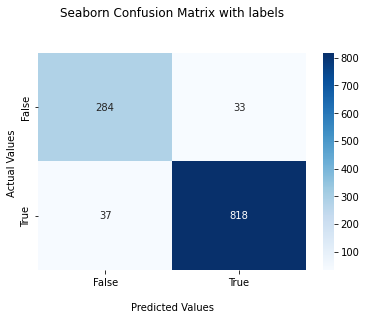

In [ ]:
def heatmap(x):
  ax = sns.heatmap(x, annot=True, fmt='', cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
heatmap(cf)

## **Result visualizing**

In [ ]:
predictions = model.predict(X_test_cnn)

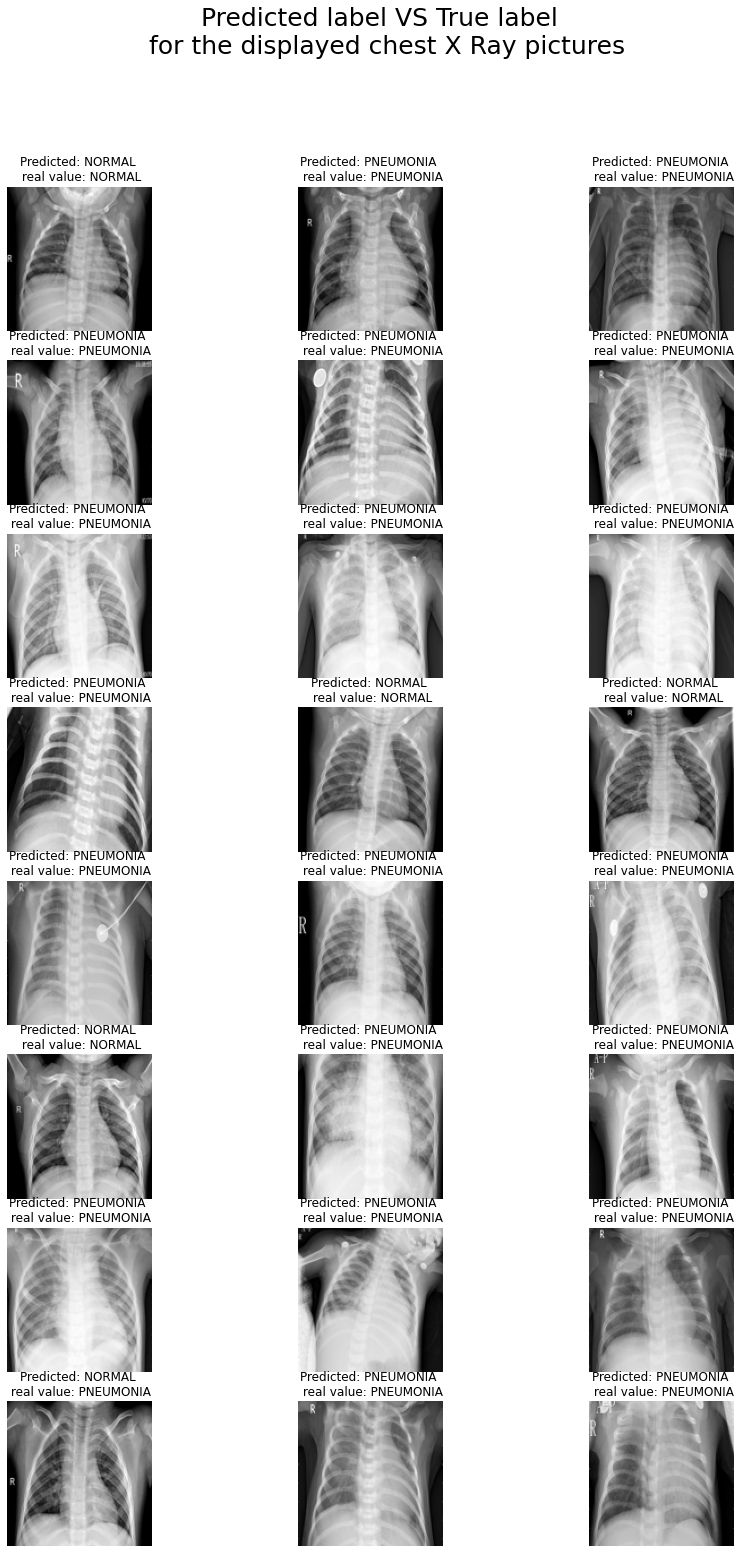

In [ ]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " \n real value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test [num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;

# **Transfer Learnings**

In [ ]:
print(X_train_tl.shape)
print(X_test_tl.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(4684, 128, 128, 3)
(1172, 128, 128, 3)
(4684,)
(1172,)


## **1. inception v3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_inception = InceptionV3(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#freezing layers
for layer in base_inception.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_inception.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

inception_model = tf.keras.models.Model(base_inception.input, x)

inception_model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
inception = inception_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 12s 120ms/step - loss: 0.0210 - acc: 0.9917 - val_loss: 0.4303 - val_acc: 0.9461
Epoch 2/20
100/100 [==============================] - 12s 116ms/step - loss: 0.0233 - acc: 0.9945 - val_loss: 0.5067 - val_acc: 0.9472
Epoch 3/20
100/100 [==============================] - 11s 115ms/step - loss: 0.0221 - acc: 0.9931 - val_loss: 0.5053 - val_acc: 0.9434
Epoch 4/20
100/100 [==============================] - 13s 127ms/step - loss: 0.0235 - acc: 0.9955 - val_loss: 0.4844 - val_acc: 0.9450
Epoch 5/20
100/100 [==============================] - 11s 114ms/step - loss: 0.0294 - acc: 0.9910 - val_loss: 0.6242 - val_acc: 0.9429
Epoch 6/20
100/100 [==============================] - 11s 114ms/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.5936 - val_acc: 0.9472
Epoch 7/20
100/100 [==============================] - 11s 115ms/step - loss: 0.0266 - acc: 0.9955 - val_loss: 0.7585 - val_acc: 0.9397
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
inception_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 3s 75ms/step - loss: 0.9448 - acc: 0.9369


[0.9448120594024658, 0.9368600845336914]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/inception_with_fake_data.sav'
pickle.dump(inception_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/inception_fit_with_fake_data.sav'
pickle.dump(inception, open(filenamefit, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_tf_with_fake_data.sav'
pickle.dump(X_test_tl, open(filename1, 'wb'))



INFO:tensorflow:Assets written to: ram://0024c074-53cb-43e4-913b-d6702fb684b5/assets
INFO:tensorflow:Assets written to: ram://a2cc8302-e2a8-445c-be5f-c0903913a865/assets


In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
x_tf = pickle.load(open(filename1, 'rb'))

loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 5s 77ms/step - loss: 0.9448 - acc: 0.9369


[0.9448120594024658, 0.9368600845336914]

In [ ]:
y_pred = loaded_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       317
           1       0.95      0.96      0.96       855

    accuracy                           0.94      1172
   macro avg       0.92      0.92      0.92      1172
weighted avg       0.94      0.94      0.94      1172

[[276  41]
 [ 33 822]]


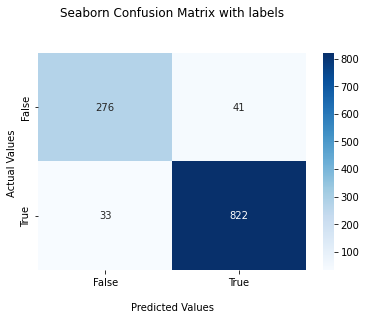

In [ ]:
heatmap(cf)

## **2. Resnet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_resnet.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_resnet.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

resnet_model = tf.keras.models.Model(base_resnet.input, x)

resnet_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
resnet = resnet_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 22s 175ms/step - loss: 0.5775 - acc: 0.7356 - val_loss: 0.5876 - val_acc: 0.7166
Epoch 2/20
100/100 [==============================] - 14s 139ms/step - loss: 0.5659 - acc: 0.7418 - val_loss: 0.5835 - val_acc: 0.7166
Epoch 3/20
100/100 [==============================] - 14s 139ms/step - loss: 0.5631 - acc: 0.7401 - val_loss: 0.5845 - val_acc: 0.7166
Epoch 4/20
100/100 [==============================] - 14s 138ms/step - loss: 0.5655 - acc: 0.7342 - val_loss: 0.5773 - val_acc: 0.7166
Epoch 5/20
100/100 [==============================] - 14s 138ms/step - loss: 0.5535 - acc: 0.7428 - val_loss: 0.5772 - val_acc: 0.7166
Epoch 6/20
100/100 [==============================] - 14s 139ms/step - loss: 0.5566 - acc: 0.7418 - val_loss: 0.5790 - val_acc: 0.7166
Epoch 7/20
100/100 [==============================] - 14s 138ms/step - loss: 0.5631 - acc: 0.7290 - val_loss: 0.5702 - val_acc: 0.7166
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
resnet_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 3s 90ms/step - loss: 0.5271 - acc: 0.7295


[0.527073085308075, 0.729522168636322]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/resnet.sav'
pickle.dump(resnet_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/resnet_fit.sav'
pickle.dump(resnet, open(filenamefit, 'wb'))


INFO:tensorflow:Assets written to: ram://b2096fd4-d9f7-459a-8b8c-c79be316b30f/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://759f6e7e-638e-46cd-9b4c-66025df47a81/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 5s 92ms/step - loss: 0.5271 - acc: 0.7295


[0.527073085308075, 0.729522168636322]

In [ ]:
y_pred = loaded_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.73      1.00      0.84       855

    accuracy                           0.73      1172
   macro avg       0.36      0.50      0.42      1172
weighted avg       0.53      0.73      0.62      1172

[[  0 317]
 [  0 855]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


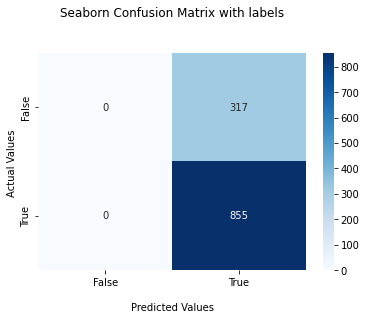

In [ ]:
heatmap(cf)

## **3. efficient net B0**


In [ ]:
base_efficient = tf.keras.applications.EfficientNetB0(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#freezing the layers
for layer in base_efficient.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_efficient.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

efficient_model = tf.keras.models.Model(base_efficient.input, x)

efficient_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
efficient = efficient_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 21s 137ms/step - loss: 0.6261 - acc: 0.7169 - val_loss: 0.6062 - val_acc: 0.7166
Epoch 2/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5953 - acc: 0.7346 - val_loss: 0.5983 - val_acc: 0.7166
Epoch 3/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5928 - acc: 0.7373 - val_loss: 0.5974 - val_acc: 0.7166
Epoch 4/20
100/100 [==============================] - 11s 111ms/step - loss: 0.5829 - acc: 0.7366 - val_loss: 0.6016 - val_acc: 0.7166
Epoch 5/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5795 - acc: 0.7428 - val_loss: 0.5976 - val_acc: 0.7166
Epoch 6/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5999 - acc: 0.7225 - val_loss: 0.6050 - val_acc: 0.7166
Epoch 7/20
100/100 [==============================] - 11s 111ms/step - loss: 0.5751 - acc: 0.7463 - val_loss: 0.5988 - val_acc: 0.7166
Epoch 8/20
100/100 [==============================] - 9s 88ms/s

In [ ]:
efficient_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 3s 70ms/step - loss: 0.5847 - acc: 0.7295


[0.584694504737854, 0.729522168636322]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/efficient.sav'
pickle.dump(efficient_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/efficient_fit.sav'
pickle.dump(efficient, open(filenamefit, 'wb'))


INFO:tensorflow:Assets written to: ram://071f22e7-6831-437f-b4da-37d98f1a9cc0/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://220d1109-c1a3-48f7-a406-951395e7ef8f/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 4s 60ms/step - loss: 0.5847 - acc: 0.7295


[0.584694504737854, 0.729522168636322]

In [ ]:
y_pred = loaded_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.73      1.00      0.84       855

    accuracy                           0.73      1172
   macro avg       0.36      0.50      0.42      1172
weighted avg       0.53      0.73      0.62      1172

[[  0 317]
 [  0 855]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


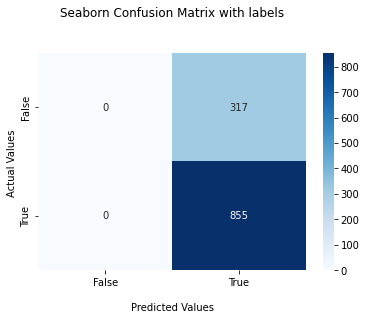

In [ ]:
heatmap(cf)

##**4. VGG 16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_vgg16.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_vgg16.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

vgg16_model = tf.keras.models.Model(base_vgg16.input, x)

vgg16_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
vgg16 = vgg16_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 14s 145ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1290 - val_acc: 0.9674
Epoch 2/20
100/100 [==============================] - 14s 142ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.1362 - val_acc: 0.9680
Epoch 3/20
100/100 [==============================] - 14s 141ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1356 - val_acc: 0.9680
Epoch 4/20
100/100 [==============================] - 14s 141ms/step - loss: 8.6540e-04 - acc: 1.0000 - val_loss: 0.1382 - val_acc: 0.9680
Epoch 5/20
100/100 [==============================] - 14s 141ms/step - loss: 9.8245e-04 - acc: 1.0000 - val_loss: 0.1397 - val_acc: 0.9701
Epoch 6/20
100/100 [==============================] - 14s 140ms/step - loss: 6.5151e-04 - acc: 1.0000 - val_loss: 0.1391 - val_acc: 0.9685
Epoch 7/20
100/100 [==============================] - 14s 141ms/step - loss: 5.7915e-04 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9685
Epoch 8/20
100/100 [===================

In [ ]:
vgg16_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 3s 89ms/step - loss: 0.2279 - acc: 0.9616


[0.22792276740074158, 0.961604118347168]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/vgg16.sav'
pickle.dump(vgg16_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/vgg16_fit.sav'
pickle.dump(vgg16, open(filenamefit, 'wb'))

INFO:tensorflow:Assets written to: ram://3f867cb9-c1d9-4be3-a4f5-c70487620208/assets
INFO:tensorflow:Assets written to: ram://bff0b68f-b917-4020-bc2e-f1245ffc0337/assets


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 4s 90ms/step - loss: 0.2279 - acc: 0.9616


[0.22792276740074158, 0.961604118347168]

In [ ]:
y_pred = loaded_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       317
           1       0.97      0.98      0.97       855

    accuracy                           0.96      1172
   macro avg       0.96      0.94      0.95      1172
weighted avg       0.96      0.96      0.96      1172

[[288  29]
 [ 16 839]]


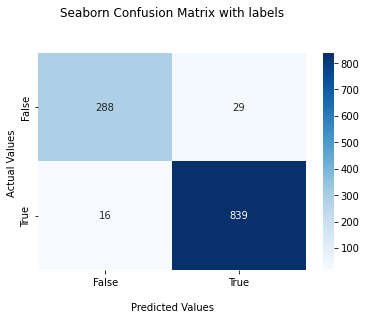

In [ ]:
heatmap(cf)

## **5. densenet 201**

In [ ]:
base_densenet = tf.keras.applications.densenet.DenseNet201(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_densenet.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_densenet.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

densenet_model = tf.keras.models.Model(base_densenet.input, x)

densenet_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
densenet = densenet_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 55s 354ms/step - loss: 0.3114 - acc: 0.8947 - val_loss: 0.1177 - val_acc: 0.9573
Epoch 2/20
100/100 [==============================] - 24s 240ms/step - loss: 0.1239 - acc: 0.9499 - val_loss: 0.1274 - val_acc: 0.9498
Epoch 3/20
100/100 [==============================] - 24s 240ms/step - loss: 0.0862 - acc: 0.9669 - val_loss: 0.1670 - val_acc: 0.9461
Epoch 4/20
100/100 [==============================] - 24s 239ms/step - loss: 0.0630 - acc: 0.9741 - val_loss: 0.1294 - val_acc: 0.9594
Epoch 5/20
100/100 [==============================] - 24s 240ms/step - loss: 0.0654 - acc: 0.9765 - val_loss: 0.1295 - val_acc: 0.9573
Epoch 6/20
100/100 [==============================] - 24s 240ms/step - loss: 0.0284 - acc: 0.9921 - val_loss: 0.1358 - val_acc: 0.9594
Epoch 7/20
100/100 [==============================] - 24s 239ms/step - loss: 0.0194 - acc: 0.9928 - val_loss: 0.1346 - val_acc: 0.9605
Epoch 8/20
100/100 [==============================] - 2

In [ ]:
densenet_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 8s 209ms/step - loss: 0.1961 - acc: 0.9684


[0.19608093798160553, 0.9684300422668457]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/densenet.sav'
pickle.dump(densenet_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/densenet_fit.sav'
pickle.dump(densenet, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://4642b1c4-7ab5-4d36-81f3-ff9fd420d5bb/assets
INFO:tensorflow:Assets written to: ram://3c294f94-14b6-4468-b790-daecd46d9f81/assets


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 10s 158ms/step - loss: 0.1814 - acc: 0.9642


[0.18135306239128113, 0.9641638398170471]

In [ ]:
y_pred = densenet_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       317
           1       0.97      0.99      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.95      0.96      1172
weighted avg       0.97      0.97      0.97      1172

[[291  26]
 [ 11 844]]


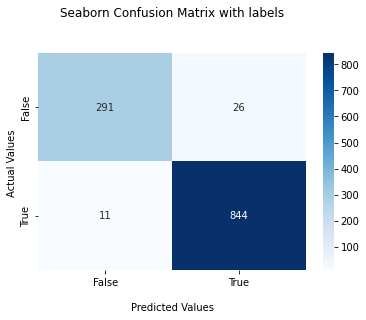

In [ ]:
heatmap(cf)

## **6. Xception**

In [ ]:
base_xception = tf.keras.applications.xception.Xception(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_xception.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_xception.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

xception_model = tf.keras.models.Model(base_xception.input, x)

xception_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
xception = xception_model.fit(X_train_tl, y_train_cat ,validation_split=0.4, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 25s 207ms/step - loss: 0.2922 - acc: 0.8861 - val_loss: 0.2285 - val_acc: 0.9125
Epoch 2/20
100/100 [==============================] - 17s 175ms/step - loss: 0.1617 - acc: 0.9396 - val_loss: 0.1889 - val_acc: 0.9258
Epoch 3/20
100/100 [==============================] - 17s 174ms/step - loss: 0.1316 - acc: 0.9486 - val_loss: 0.2249 - val_acc: 0.9205
Epoch 4/20
100/100 [==============================] - 17s 173ms/step - loss: 0.1199 - acc: 0.9551 - val_loss: 0.1808 - val_acc: 0.9312
Epoch 5/20
100/100 [==============================] - 21s 215ms/step - loss: 0.0915 - acc: 0.9662 - val_loss: 0.1870 - val_acc: 0.9397
Epoch 6/20
100/100 [==============================] - 17s 173ms/step - loss: 0.0893 - acc: 0.9662 - val_loss: 0.1798 - val_acc: 0.9402
Epoch 7/20
100/100 [==============================] - 17s 174ms/step - loss: 0.0621 - acc: 0.9769 - val_loss: 0.2068 - val_acc: 0.9322
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
xception_model.evaluate(X_test_tl, y_test_cat)

37/37 [==============================] - 5s 123ms/step - loss: 0.2504 - acc: 0.9403


[0.25038740038871765, 0.9402730464935303]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/xception.sav'
pickle.dump(xception_model, open(filename, 'wb'))
filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/xception_fit.sav'
pickle.dump(xception, open(filenamefit, 'wb'))


INFO:tensorflow:Assets written to: ram://0e03f249-04f1-43df-bac1-44bcbb076cf8/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://ffd222c0-537c-46cd-a29c-52e52797f1a5/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
x_xception = pickle.load(open(filename1, 'rb'))
y_xception = pickle.load(open(filename2, 'rb'))

loaded_model.evaluate(x_tf, y, verbose=1)

37/37 [==============================] - 5s 110ms/step - loss: 0.2193 - acc: 0.9522


[0.219273641705513, 0.9522184133529663]

In [ ]:
y_pred = xception_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       317
           1       0.96      0.96      0.96       855

    accuracy                           0.94      1172
   macro avg       0.93      0.92      0.92      1172
weighted avg       0.94      0.94      0.94      1172

[[281  36]
 [ 34 821]]


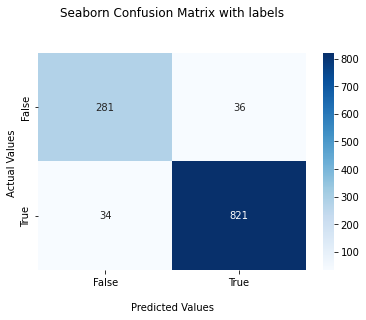

In [ ]:
heatmap(cf)